# Demo ClipCap MLP model

In [40]:
import torch
import clip
import numpy as np
from torch import nn
from typing import Tuple, List, Union, Optional
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel
)
from enum import Enum

class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'

class PromptType(Enum):
    Empty = "empty"
    Orginal = 'original'
    OriginalWithWords = 'originalplus'
N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]
D = torch.device
CPU = torch.device("cpu")

## Models

In [41]:

class MLP(nn.Module):
    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    # @functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(
            batch_size, self.prefix_length, dtype=torch.int64, device=device
        )

    def forward(
        self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None
    ):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(
            -1, self.prefix_length, self.gpt_embedding_size
        )
        # print(embedding_text.size()) #torch.Size([5, 67, 768])
        # print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained("gpt2")
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(
                prefix_size, self.gpt_embedding_size * prefix_length
            )
        else:
            self.clip_project = MLP(
                (
                    prefix_size,
                    (self.gpt_embedding_size * prefix_length) // 2,
                    self.gpt_embedding_size * prefix_length,
                )
            )

In [55]:

class PromptedCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def pad_tokens(self, tokens):
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask
    
    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        device = tokens.device
        if self.training:
            embedding_text = self.gpt.transformer.wte(tokens)
        # else:
        #     original_text = self.original_model(tokens, prefix, mask, labels)
        #     original_text = f"Describe {original_text} like an instagram caption"
        #     prepend_tokens = self.tokenizer.encode(original_text, return_tensors="pt").to(device)
        #     embedding_text = self.gpt.transformer.wte(prepend_tokens)

        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP, 
                 prompt_mode: PromptType = PromptType.OriginalWithWords, weights_path: str = "coco_weights.pt" ):
        super(PromptedCaptionModel, self).__init__()
        self.max_seq_len = 77
        self.prompt_mode = prompt_mode
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(
                prefix_size, self.gpt_embedding_size * prefix_length
            )
        else:
            self.clip_project = MLP(
                (
                    prefix_size,
                    (self.gpt_embedding_size * prefix_length) // 2,
                    self.gpt_embedding_size * prefix_length,
                )
            )

        if self.prompt_mode == PromptType.OriginalWithWords:
            self.original_model = ClipCaptionModel(prefix_length)
            state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
            self.original_model.load_state_dict(state_dict, strict=False)
            # Freeze the model parameters
            for param in self.original_model.parameters():
                param.requires_grad = False
            

In [56]:
def generate2(
    model,
    tokenizer,
    tokens=None,
    prompt=None,
    embed=None,
    entry_count=1,
    entry_length=67,  # maximum number of words
    top_p=0.8,
    temperature=1.0,
    stop_token: str = ".",
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in range(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(
                    nn.functional.softmax(sorted_logits, dim=-1), dim=-1
                )
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

## Get pretrained weights into model

In [57]:
device = "cpu"
prefix_length = 10

In [58]:
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [59]:
model = ClipCaptionModel(prefix_length)
model.load_state_dict(torch.load("coco_weights.pt", map_location=CPU), strict=False)
model = model.eval()
model = model.to(device)







In [60]:
model_finetuned = ClipCaptionModel(prefix_length)
model_finetuned.load_state_dict(torch.load("base_weights.pt", map_location=CPU), strict=False)
model_finetuned = model_finetuned.eval()
model_finetuned = model_finetuned.to(device)

In [61]:
model_finetuned_prompted = PromptedCaptionModel(prefix_length)
model_finetuned_prompted.load_state_dict(torch.load("prompted_weights2.pt", map_location=CPU), strict=False)
model_finetuned_prompted = model_finetuned_prompted.eval()
model_finetuned_prompted = model_finetuned_prompted.to(device)

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [33]:
print(model)

ClipCaptionModel(
  (gpt): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
  (clip_project): MLP(
    (model

## Use test image

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

In [24]:
pil_image = Image.open("person.jpg")

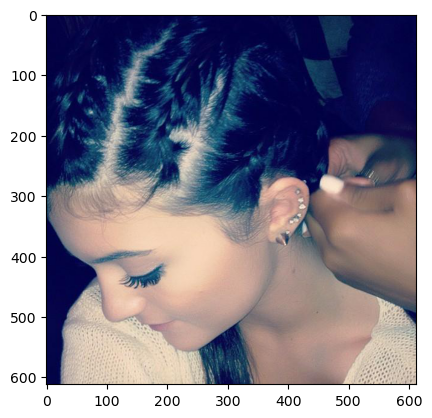

In [25]:
plt.imshow(pil_image)
plt.show()

In [26]:
image = preprocess(pil_image).unsqueeze(0).to(device)

In [27]:
prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
prefix.shape

torch.Size([1, 512])

In [28]:
prefix_embedding = model.clip_project(prefix).reshape(1, prefix_length, -1)
prefix_embedding.shape

torch.Size([1, 10, 768])

In [34]:
generated_text = generate2(model, tokenizer, embed=prefix_embedding)
generated_text_finetuned = generate2(model_finetuned, tokenizer, embed=prefix_embedding)
generated_text_finetuned_prompt = generate2(model_finetuned_prompted, tokenizer, embed=prefix_embedding)

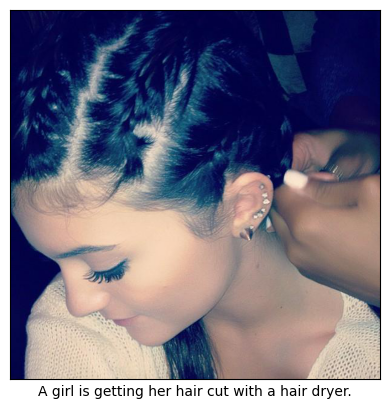

In [35]:
plt.imshow(pil_image)
plt.yticks([])
plt.xticks([])
plt.xlabel(generated_text)
plt.show()

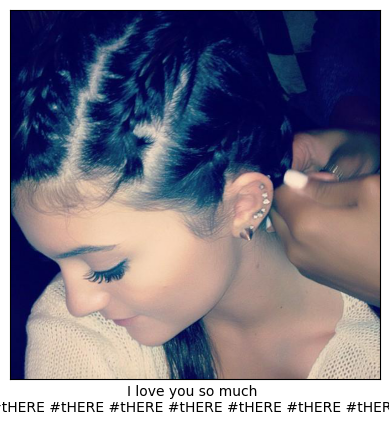

In [36]:
plt.imshow(pil_image)
plt.yticks([])
plt.xticks([])
plt.xlabel(generated_text_finetuned)
plt.show()

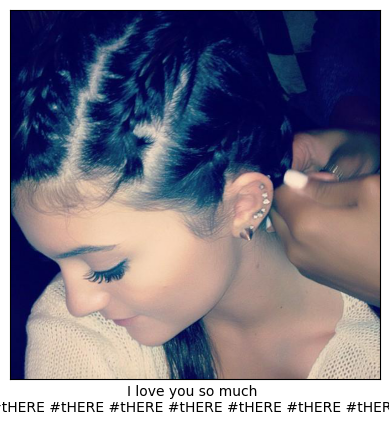

In [37]:
plt.imshow(pil_image)
plt.yticks([])
plt.xticks([])
plt.xlabel(generated_text_finetuned_prompt)
plt.show()

## Use random image from my camera roll

In [51]:
pil_image = Image.open("dawg.jpg")
image = preprocess(pil_image).unsqueeze(0).to(device)
prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
prefix_embedding = model.clip_project(prefix).reshape(1, prefix_length, -1)
generated_text = generate2(model, tokenizer, embed=prefix_embedding)

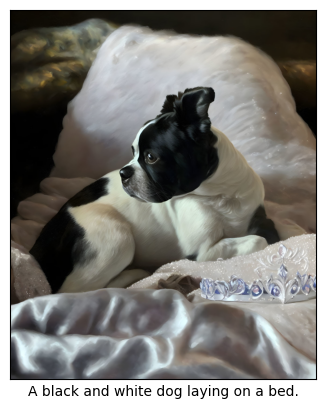

In [52]:
plt.imshow(pil_image)
plt.yticks([])
plt.xticks([])
plt.xlabel(generated_text)
plt.show()